# data analysis and plotting results

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from os.path import join as pjoin
import seaborn as sns
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':'tight'}

## general definitions

In [2]:
result_dir = "../results/"
figures_dir = "../figures/"

In [3]:
sns.set()
sns.set_style('ticks')
sns.set_context('paper',rc={"font.size":8,"axes.titlesize":8,"axes.labelsize":8})

In [4]:
# Colour scheme

col_clean = tuple(x/255.0 for x in (50, 65, 75))
col_stylized = tuple(x/255.0 for x in (180, 160, 105))
col_combined = tuple(x/255.0 for x in (165, 30, 55))

In [5]:
# plotting parameters

combined_plot_height = 5.0
combined_plot_width = 6.0

markersize = 16
fontsize = 24
linewidth = 2.5
labelsize = 18
legend_fontsize=18
axis_start = -0.2
axis_end = 5.3


In [6]:
def get_results_coco_cityscapes(eval_output, base_performance, task='bbox', metric='AP', verbose=0):
    
    metrics = {'AP':0, 'AP50':1, 'AP75':2, 'APs':3, 'APm':4, 'APl':5, 
               'AR1':6, 'AR10':7, 'AR100':8, 'ARs':9, 'ARm':10, 'ARl':11}
    assert metric in metrics.keys()
    metric_index = metrics[metric]

    results = np.zeros((20,6), dtype='float32')
    results[:,0] = base_performance

    for i, distortion in enumerate(eval_output):
        for severity in eval_output[distortion]:
            mAP = eval_output[distortion][severity][task][metric_index]
            results[i, severity] = mAP
            if verbose > 0:
                print(distortion, severity, mAP)
                
    return results

def get_distortions(eval_output):
    distortions = []
    for i, distortion in enumerate(eval_output):
        distortions.append(distortion.replace("_", " "))
    return distortions

In [7]:
def plot_individual_results(clean_data, stylized_data, combined_data, plot_name, metric_name,
                            ylim, legend_loc=1, markersize=12, linewidth=2.0,
                            fontsize=15, legend_fontsize=11.3, labelsize=12.0):

    fig = plt.figure(figsize = (15.0, 20.0))
    plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

    for i, distortion in enumerate(distortions[0:15]): # only plot first 15 distortions, not the validation distortions
        ax = plt.subplot(5,3,i+1)

        plt.plot(list(range(6)), clean_data[i,:] * 100, 's-', zorder=2, color=col_clean,
                 label='standard data', markersize=markersize, linewidth=linewidth)
        plt.plot(list(range(6)), stylized_data[i,:] * 100, '^-', zorder=1, color=col_stylized,
                 label='stylized data', markersize=markersize, linewidth=linewidth)
        plt.plot(list(range(6)), combined_data[i,:] * 100, 'o-', zorder=3, color=col_combined,
                 label='combined data', markersize=markersize, linewidth=linewidth)


        plt.title(distortion, fontsize=fontsize)    
        if i >= 12: # plot xlabel only in last row
            plt.xlabel('corruption severity', fontsize=fontsize)
        if i % 3 == 0:
            plt.ylabel(metric_name, fontsize=fontsize)
        plt.axis([axis_start, axis_end, ylim[0], ylim[1]])
        if i == 0:
            legend = plt.legend(loc=legend_loc, fontsize=legend_fontsize, frameon=True, edgecolor="black")
            legend.get_frame().set_linewidth(1.0)

        ax.tick_params(axis='both', which='major', labelsize=labelsize)


    sns.despine(trim=True, offset=5)

    plt.show()

    fig.savefig(pjoin(figures_dir, plot_name), bbox_inches='tight')
    

### Pascal VOC

In [8]:
def get_results_voc(eval_output, base_performance, verbose=0):

    results = np.zeros((20,6), dtype='float32')
    results[:,0] = base_performance

    for i, distortion in enumerate(eval_output):
        for severity in eval_output[distortion]:
            mAP = np.mean([eval_output[distortion][severity][j]['ap'] for j in range(len(eval_output[distortion][severity]))])
            results[i, severity] = mAP
            if verbose > 0:
                print(distortion, severity, mAP)
                
    return results

In [9]:
with open(pjoin(result_dir, "faster_rcnn_r50_fpn_1x_2gpu_voc0712_all_1-5_results.pkl"), "rb") as f:
    voc_out = pickle.load(f)
with open(pjoin(result_dir, "faster_rcnn_r50_fpn_1x_1gpu_svoc0712_all_1-5_results.pkl"), "rb") as f:
    svoc_out = pickle.load(f)
with open(pjoin(result_dir, "faster_rcnn_r50_fpn_1x_4gpu_voc0712svoc0712_all_1-5_results.pkl"), "rb") as f:
    voc_svoc_out = pickle.load(f)
with open(pjoin(result_dir, "faster_rcnn_r50_fpn_1x_2gpu_voc0712svoc0712_short_all_1-5_results.pkl"), "rb") as f:
    voc_svoc_short_out = pickle.load(f)

In [10]:
distortions = get_distortions(voc_out)

In [11]:
voc_results = get_results_voc(voc_out, base_performance=0.805)
svoc_results = get_results_voc(svoc_out, base_performance=0.680)
voc_svoc_results = get_results_voc(voc_svoc_out, base_performance=0.804)
voc_svoc_short_results = get_results_voc(voc_svoc_short_out, base_performance=0.774)

pre_voc_results = get_results_voc(voc_out, base_performance=0.804)
pre_svoc_results = get_results_voc(svoc_out, base_performance=0.734)
pre_voc_svoc_results = get_results_voc(voc_svoc_out, base_performance=0.806)
pre_voc_svoc_short_results = get_results_voc(voc_svoc_short_out, base_performance=0.807)

In [12]:
# absolute performance under corruption
print(np.mean(voc_results[:15,1:]), 
      np.mean(svoc_results[:15,1:]), 
      np.mean(voc_svoc_results[:15,1:]))

# realtive performance
print(np.mean(voc_results[:15,1:])/voc_results[0,0], 
      np.mean(svoc_results[:15,1:])/svoc_results[0,0], 
      np.mean(voc_svoc_results[:15,1:])/voc_svoc_results[0,0])

0.48611867 0.49975255 0.5616002
0.60387415 0.7349302 0.6985077


In [13]:
def set_fontsize_helper(ax, fontsize):
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fontsize)

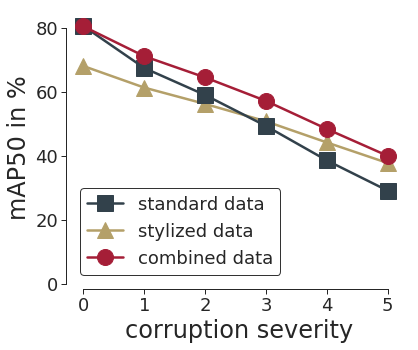

In [14]:
# Pascal VOC combined=averaged plot

fig = plt.figure(figsize = (combined_plot_width, combined_plot_height))

ax = plt.subplot(1,1,1)
plt.plot(list(range(6)), np.mean(voc_results[:15,:], axis=0) * 100,
         's-', zorder=2, color=col_clean, label='standard data', markersize=markersize,
        linewidth=linewidth)
plt.plot(list(range(6)), np.mean(svoc_results[:15,:], axis=0) * 100,
         '^-', zorder=1, color=col_stylized, label='stylized data', markersize=markersize,
        linewidth=linewidth)
plt.plot(list(range(6)), np.mean(voc_svoc_results[:15,:], axis=0) * 100,
         'o-', zorder=3, color=col_combined, label='combined data', markersize=markersize,
        linewidth=linewidth)

plt.xlabel('corruption severity', fontsize=fontsize)
plt.ylabel('mAP50 in %', fontsize=fontsize)
plt.axis([axis_start, axis_end, 0, 85])
ax.tick_params(axis='both', which='major', labelsize=labelsize)
legend = plt.legend(loc=3, fontsize=legend_fontsize, frameon=True, edgecolor="black")
legend.get_frame().set_linewidth(1.0)

sns.despine(trim=True, offset=5)

plt.show()

fig.savefig(pjoin(figures_dir, 'pascal_corruption_overall.pdf'), bbox_inches='tight')

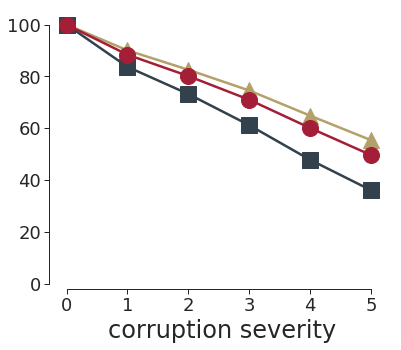

In [15]:
# relative plot

fig = plt.figure(figsize = (combined_plot_width, combined_plot_height))

ax = plt.subplot(1,1,1)
plt.plot(list(range(6)), np.mean(voc_results[:15,:], axis=0)/voc_results[0,0] * 100,
         's-', zorder=2, color=col_clean, label='pascal voc', markersize=markersize,
        linewidth=linewidth)
plt.plot(list(range(6)), np.mean(svoc_results[:15,:], axis=0)/svoc_results[0,0] * 100,
         '^-', zorder=1, color=col_stylized, label='stylized voc', markersize=markersize,
        linewidth=linewidth)
plt.plot(list(range(6)), np.mean(voc_svoc_results[:15,:], axis=0)/voc_svoc_results[0,0] * 100,
         'o-', zorder=3, color=col_combined, label='combined', markersize=markersize,
        linewidth=linewidth)

plt.xlabel('corruption severity', fontsize=fontsize)
plt.axis([axis_start, axis_end, 0, 105])
ax.tick_params(axis='both', which='major', labelsize=labelsize)

sns.despine(trim=True, offset=5)

plt.show()

fig.savefig(pjoin(figures_dir, 'pascal_corruption_overall_relative.pdf'), bbox_inches='tight')

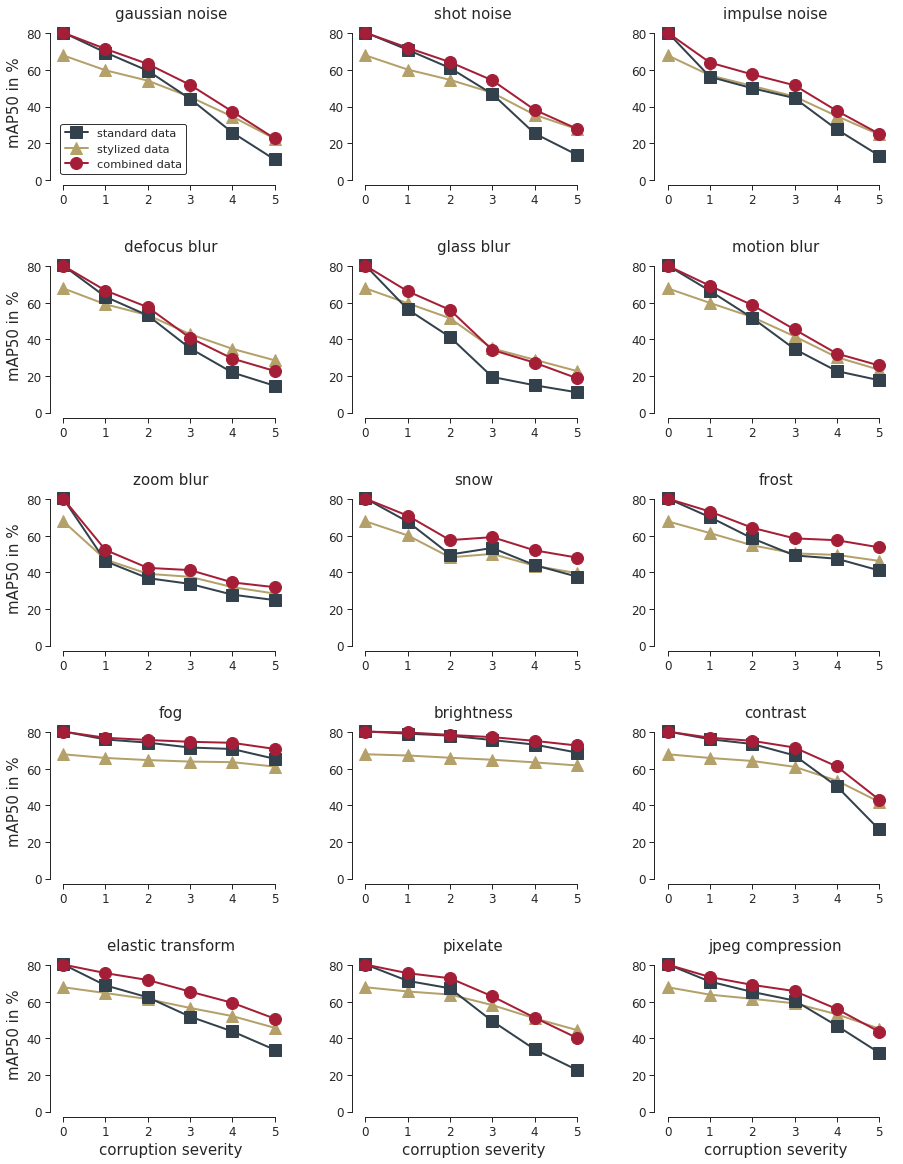

In [16]:
plot_individual_results(clean_data = voc_results,
                        stylized_data=svoc_results,
                        combined_data=voc_svoc_results,
                        plot_name="pascal_corruption_individual.pdf",
                        metric_name="mAP50 in %", ylim=[0, 85], legend_loc=3)

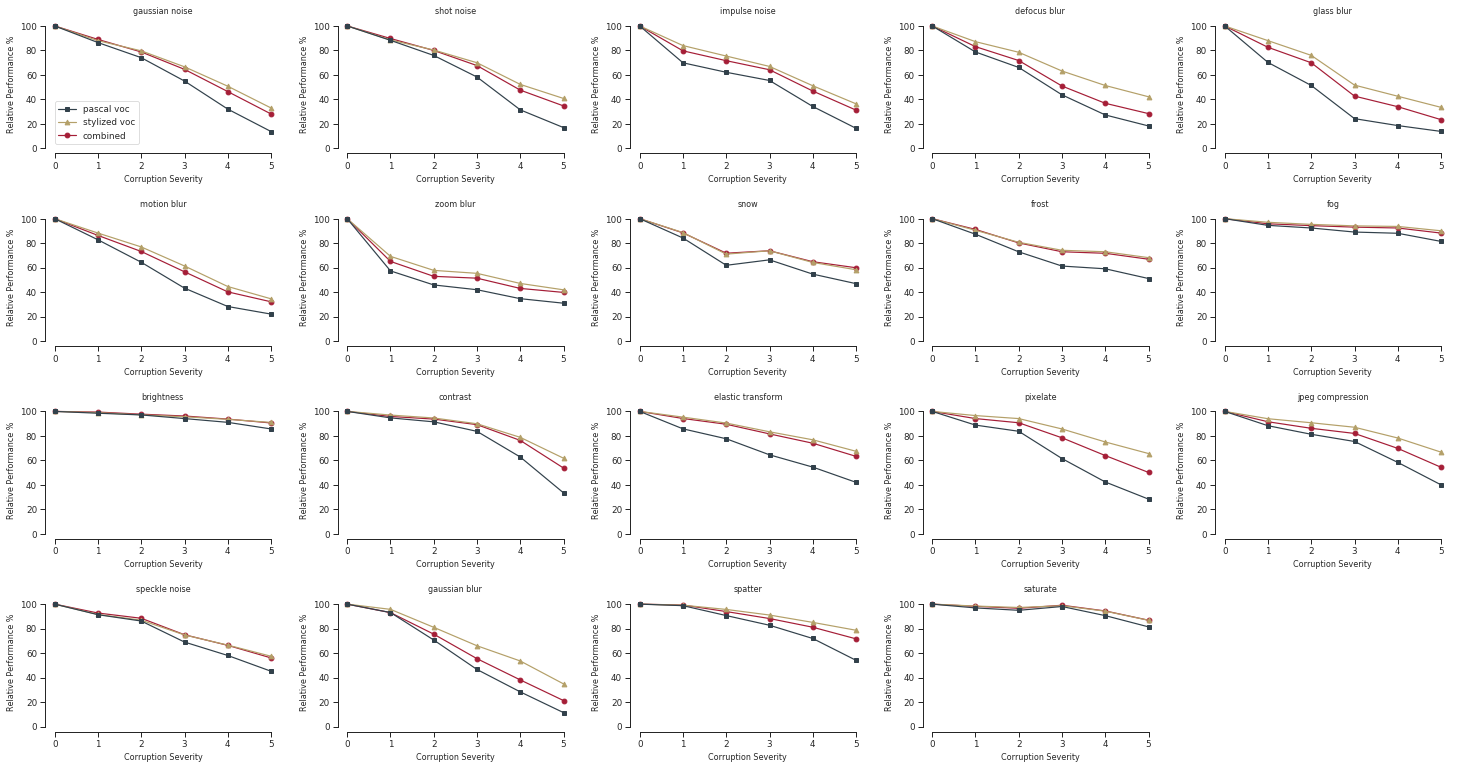

In [17]:
fig = plt.figure(figsize = (25.0, 13.0))
plt.subplots_adjust(wspace = 0.3, hspace = 0.5)

for i, distortion in enumerate(distortions):
    plt.subplot(4,5,i+1)

    plt.plot(list(range(6)), voc_results[i,:]/voc_results[i,0] * 100, 's-', zorder=3, color=col_clean, label='pascal voc')
    plt.plot(list(range(6)), svoc_results[i,:]/svoc_results[i,0] * 100, '^-', zorder=2, color=col_stylized, label='stylized voc')
    plt.plot(list(range(6)), voc_svoc_results[i,:]/voc_svoc_results[i,0] * 100, 'o-', zorder=1, color=col_combined, label='combined')


    plt.title(distortion)
    plt.xlabel('Corruption Severity')
    plt.ylabel('Relative Performance %')
    plt.axis([-0.1,5.1,0,105])
    if i == 0:
        plt.legend(loc=3)


sns.despine(trim=True, offset=5)

plt.show()

fig.savefig(pjoin(figures_dir, "pascal_corruption_individual_relative.pdf"), bbox_inches='tight')

### MS COCO

In [18]:
with open(pjoin(result_dir, "faster_rcnn_r50_fpn_1x_4gpu_coco_all_1-5_results.pkl"), "rb") as f:
    coco_out = pickle.load(f)
with open(pjoin(result_dir, "faster_rcnn_r50_fpn_1x_4gpu_scoco_all_1-5_results.pkl"), "rb") as f:
    scoco_out = pickle.load(f)
with open(pjoin(result_dir, "faster_rcnn_r50_fpn_1x_4gpu_cocoscoco_all_1-5_results.pkl"), "rb") as f:
    coco_scoco_out = pickle.load(f)

In [19]:
distortions = get_distortions(coco_out)

In [20]:
coco_results = get_results_coco_cityscapes(coco_out, base_performance=0.363)
scoco_results = get_results_coco_cityscapes(scoco_out, base_performance=0.215)
coco_scoco_results = get_results_coco_cityscapes(coco_scoco_out, base_performance=0.346)

In [21]:
# absolute performance under corruption
print(np.mean(coco_results[:15,1:]), 
      np.mean(scoco_results[:15,1:]), 
      np.mean(coco_scoco_results[:15,1:]))

# realtive performance
print(np.mean(coco_results[:15,1:])/coco_results[0,0], 
      np.mean(scoco_results[:15,1:])/scoco_results[0,0], 
      np.mean(coco_scoco_results[:15,1:])/coco_scoco_results[0,0])

0.1820489 0.14098507 0.20387988
0.5015121 0.6557445 0.58924824


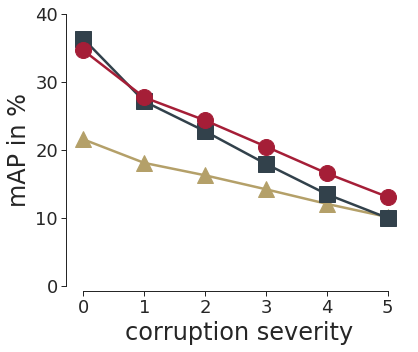

In [22]:
# MS COCO combined results

fig = plt.figure(figsize = (combined_plot_width, combined_plot_height))

ax = plt.subplot(1,1,1)

plt.plot(list(range(6)), np.mean(coco_results[:15,:], axis=0) * 100,
         's-', zorder=2, color=col_clean, label='coco', markersize=markersize,
        linewidth=linewidth)
plt.plot(list(range(6)), np.mean(scoco_results[:15,:], axis=0) * 100,
         '^-', zorder=1, color=col_stylized, label='stylized coco', markersize=markersize,
        linewidth=linewidth)
plt.plot(list(range(6)), np.mean(coco_scoco_results[:15,:], axis=0) * 100,
         'o-', zorder=3, color=col_combined, label='combined', markersize=markersize,
        linewidth=linewidth)


plt.xlabel('corruption severity', fontsize=fontsize)
plt.ylabel('mAP in %', fontsize=fontsize)
plt.axis([axis_start, axis_end, 0, 40])
ax.tick_params(axis='both', which='major', labelsize=labelsize)

sns.despine(trim=True, offset=5)

plt.show()

fig.savefig(pjoin(figures_dir, "coco_corruption_overall.pdf"), bbox_inches='tight')

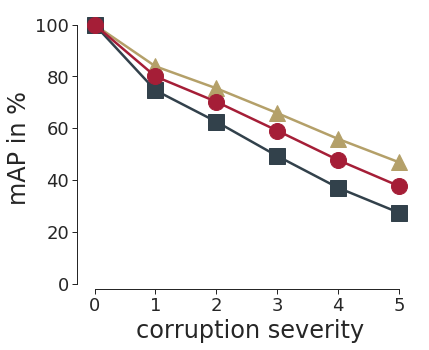

In [41]:
# MS COCO combined relative results

fig = plt.figure(figsize = (combined_plot_width, combined_plot_height))

ax = plt.subplot(1,1,1)

plt.plot(list(range(6)), np.mean(coco_results[:15,:], axis=0)/coco_results[0,0] * 100,
         's-', zorder=2, color=col_clean, label='standard data', markersize=markersize,
        linewidth=linewidth)
plt.plot(list(range(6)), np.mean(scoco_results[:15,:], axis=0)/scoco_results[0,0] * 100,
         '^-', zorder=1, color=col_stylized, label='stylized data', markersize=markersize,
        linewidth=linewidth)
plt.plot(list(range(6)), np.mean(coco_scoco_results[:15,:], axis=0)/coco_scoco_results[0,0] * 100,
         'o-', zorder=3, color=col_combined, label='combined data', markersize=markersize,
        linewidth=linewidth)


plt.xlabel('corruption severity', fontsize=fontsize)
plt.ylabel('mAP in %', fontsize=fontsize)
plt.axis([axis_start, axis_end, 0, 105])
ax.tick_params(axis='both', which='major', labelsize=labelsize)

sns.despine(trim=True, offset=5)

plt.show()

fig.savefig(pjoin(figures_dir, "coco_corruption_overall_relative.pdf"), bbox_inches='tight')

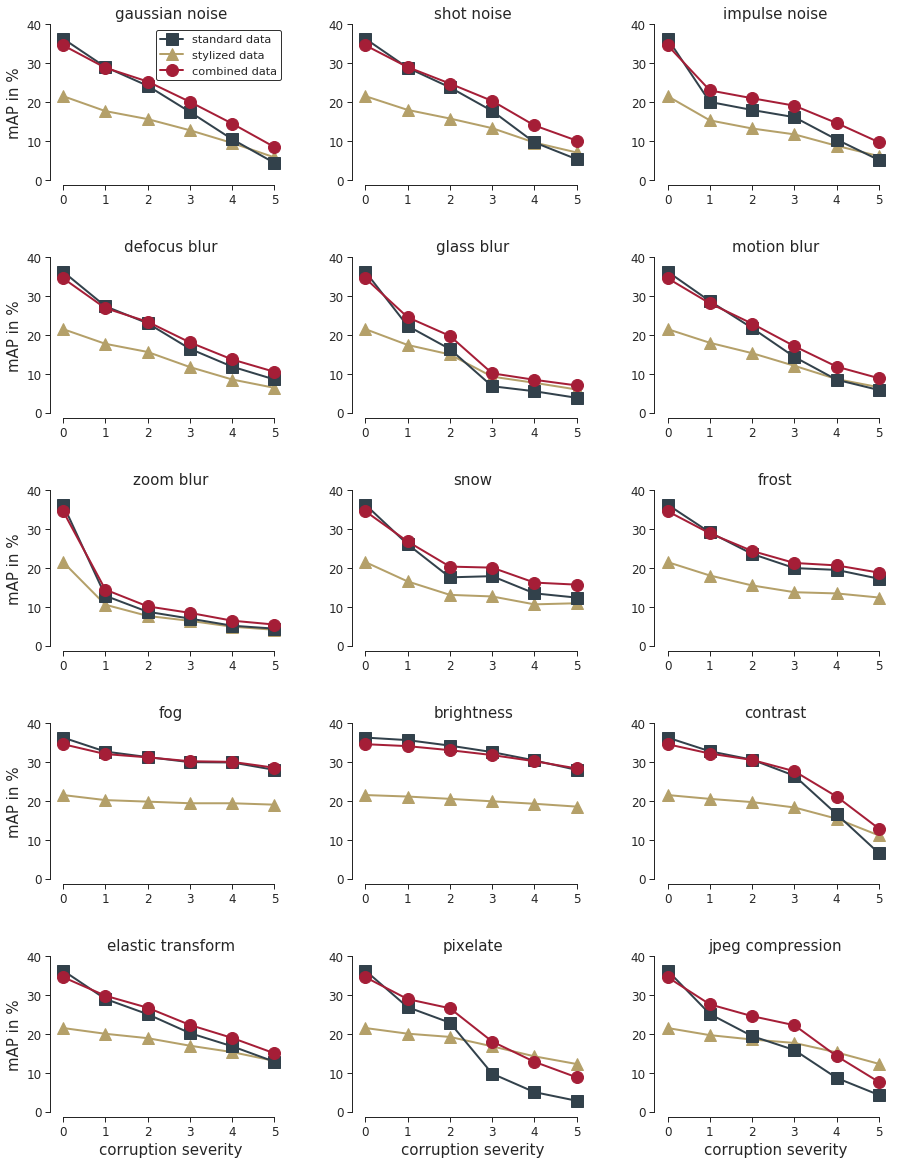

In [42]:
plot_individual_results(clean_data = coco_results,
                        stylized_data=scoco_results,
                        combined_data=coco_scoco_results,
                        plot_name="coco_corruption_individual.pdf",
                        metric_name="mAP in %", ylim=[0, 40])

## Citscapes

In [43]:
with open(pjoin(result_dir, "faster_rcnn_r50_fpn_1x_1gpu_city_all_1-5_results.pkl"), "rb") as f:
    city_out = pickle.load(f)
with open(pjoin(result_dir, "faster_rcnn_r50_fpn_1x_1gpu_scity_all_1-5_results.pkl"), "rb") as f:
    scity_out = pickle.load(f)
with open(pjoin(result_dir, "faster_rcnn_r50_fpn_1x_1gpu_cityscity_all_1-5_results.pkl"), "rb") as f:
    city_scity_out = pickle.load(f)

distortions = get_distortions(city_out)

In [44]:
city_results = get_results_coco_cityscapes(city_out, base_performance=0.292)
scity_results = get_results_coco_cityscapes(scity_out, base_performance=0.237)
city_scity_results = get_results_coco_cityscapes(city_scity_out, base_performance=0.284)

In [45]:
# absolute performance under corruption
print(np.mean(city_results[:15,1:]), 
      np.mean(scity_results[:15,1:]), 
      np.mean(city_scity_results[:15,1:]))

    # realtive performance
print(np.mean(city_results[:15,1:])/city_results[0,0], 
      np.mean(scity_results[:15,1:])/scity_results[0,0], 
      np.mean(city_scity_results[:15,1:])/city_scity_results[0,0])

0.118121974 0.13882723 0.16473988
0.4045273 0.58576894 0.58006996


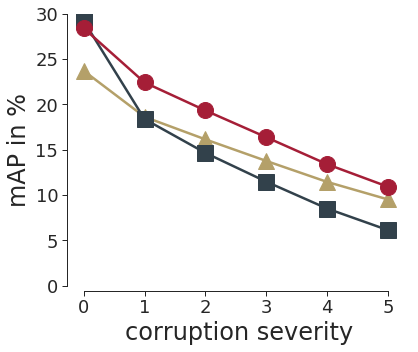

In [46]:
# Cityscapes combined results

fig = plt.figure(figsize = (combined_plot_width, combined_plot_height))

ax = plt.subplot(1,1,1)

plt.plot(list(range(6)), np.mean(city_results[:15,:], axis=0) * 100,
         's-', zorder=2, color=col_clean, label='standard data', markersize=markersize,
        linewidth=linewidth)
plt.plot(list(range(6)), np.mean(scity_results[:15,:], axis=0) * 100,
         '^-', zorder=1, color=col_stylized, label='stylized data', markersize=markersize,
        linewidth=linewidth)
plt.plot(list(range(6)), np.mean(city_scity_results[:15,:], axis=0) * 100,
         'o-', zorder=3, color=col_combined, label='including stylized data', markersize=markersize,
        linewidth=linewidth)


plt.xlabel('corruption severity', fontsize=fontsize)
plt.ylabel('mAP in %', fontsize=fontsize)
plt.axis([axis_start, axis_end, 0, 30])
ax.tick_params(axis='both', which='major', labelsize=labelsize)

sns.despine(trim=True, offset=5)

plt.show()

fig.savefig(pjoin(figures_dir, "cityscapes_corruption_overall.pdf"), bbox_inches='tight')

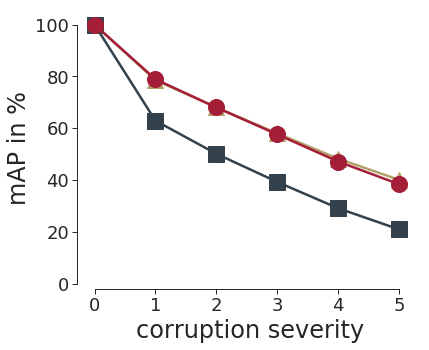

In [47]:
# Cityscapes combined relative results

fig = plt.figure(figsize = (combined_plot_width, combined_plot_height))

ax = plt.subplot(1,1,1)

plt.plot(list(range(6)), np.mean(city_results[:15,:], axis=0)/city_results[0,0] * 100,
         's-', zorder=2, color=col_clean, label='standard data', markersize=markersize,
        linewidth=linewidth)
plt.plot(list(range(6)), np.mean(scity_results[:15,:], axis=0)/scity_results[0,0] * 100,
         '^-', zorder=1, color=col_stylized, label='stylized data', markersize=markersize,
        linewidth=linewidth)
plt.plot(list(range(6)), np.mean(city_scity_results[:15,:], axis=0)/city_scity_results[0,0] * 100,
         'o-', zorder=3, color=col_combined, label='combined data', markersize=markersize,
        linewidth=linewidth)


plt.xlabel('corruption severity', fontsize=fontsize)
plt.ylabel('mAP in %', fontsize=fontsize)
plt.axis([axis_start, axis_end, 0, 105])
ax.tick_params(axis='both', which='major', labelsize=labelsize)

sns.despine(trim=True, offset=5)

plt.show()

fig.savefig(pjoin(figures_dir, "cityscapes_corruption_overall_relative.pdf"), bbox_inches='tight')

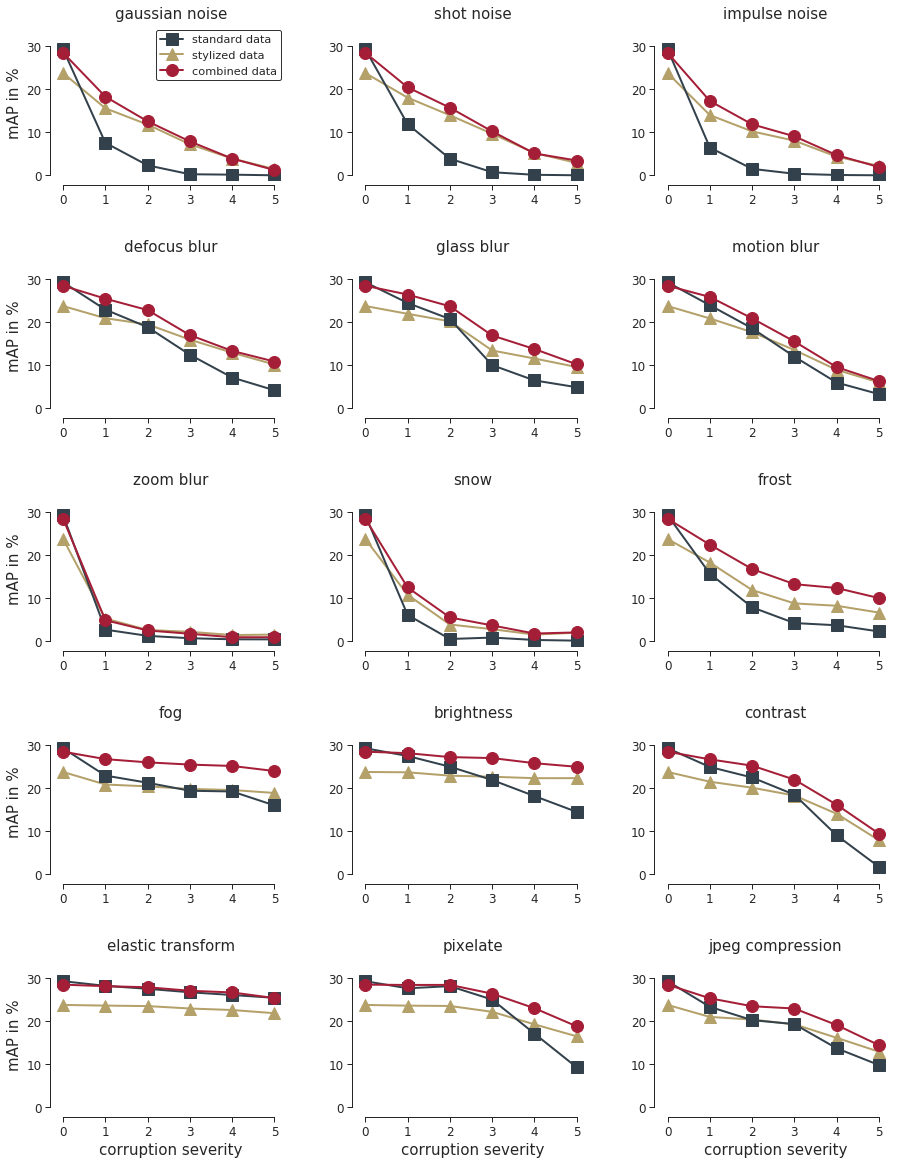

In [48]:
plot_individual_results(clean_data = city_results,
                        stylized_data=scity_results,
                        combined_data=city_scity_results,
                        plot_name="cityscapes_corruption_individual.pdf",
                        metric_name="mAP in %", ylim=[-1, 35])